In [121]:
#histgradboost
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

#__file__ = Path('submissions') /  'my_submission1' /  'estimator.py'

def _encode(X):
    #cyclical encoding of dates
    X = X.copy()
    year_norm = 2 * np.pi * X['date'].dt.year / X['date'].dt.year.max()
    month_norm = 2 * np.pi * X['date'].dt.month / X['date'].dt.month.max()
    day_norm = 2 * np.pi * X['date'].dt.day / X['date'].dt.day.max()
    weekday_norm = 2 * np.pi * X['date'].dt.weekday / X['date'].dt.weekday.max()
    hour_norm = 2 * np.pi * X['date'].dt.hour / X['date'].dt.hour.max()
    X.loc[:, 'year_sin'] = np.sin(year_norm)
    X.loc[:, 'year_cos'] = np.cos(year_norm)
    X.loc[:, 'month_sin'] = np.sin(month_norm)
    X.loc[:, 'month_cos'] = np.cos(month_norm)
    X.loc[:, 'day_sin'] = np.sin(day_norm)
    X.loc[:, 'day_cos'] = np.cos(day_norm)
    X.loc[:, 'weekday_sin'] = np.sin(weekday_norm)
    X.loc[:, 'weekday_cos'] = np.cos(weekday_norm)
    X.loc[:, 'hour_sin'] = np.sin(hour_norm)
    X.loc[:, 'hour_cos'] = np.cos(hour_norm)
    #encode dates
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour
    return X.drop(columns=["date"]) 

def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'ff', 'u', 'brent', 'holidays', 'curfew', 'rush hour', 'Taux', 'bike']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X

def get_estimator():
    date_encoder = FunctionTransformer(_encode)
    cycl_cols = ['month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
    date_cols = ['year', 'day']

    categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    categorical_cols = ["site_name", "counter_name"]
    binary_cols =  ['curfew']
    numeric_cols = ['Taux', 'bike', 't', 'brent', 'ff']

    preprocessor = ColumnTransformer(
        [
            ('date', 'passthrough', date_cols),
            ('cycl', 'passthrough', cycl_cols),
            ('holiday', 'passthrough', binary_cols),
            ('cat', categorical_encoder, categorical_cols),
            ('numeric', 'passthrough', numeric_cols)
        ]
    )
    regressor = HistGradientBoostingRegressor(random_state=0, max_leaf_nodes=300, max_iter=150)

    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False), date_encoder, preprocessor, regressor)

    return pipe


In [122]:
import problem

data = pd.read_parquet(Path('data') / 'train.parquet')


X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

<AxesSubplot:title={'center':'Different hourly values between counters'}, xlabel='date'>

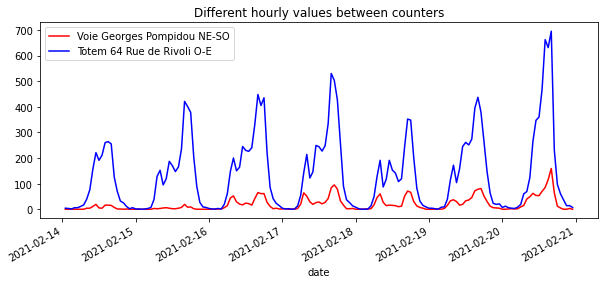

In [123]:
fig, ax = plt.subplots(figsize=(10, 4))

mask1 = ((data['counter_name'] == 'Voie Georges Pompidou NE-SO')
        & (data['date'] > pd.to_datetime('2021/02/14'))
        & (data['date'] < pd.to_datetime('2021/02/21')))

mask2 = ((data['counter_name'] == 'Totem 64 Rue de Rivoli O-E')
        & (data['date'] > pd.to_datetime('2021/02/14'))
        & (data['date'] < pd.to_datetime('2021/02/21')))

data[mask1].plot(x='date', y='bike_count', ax=ax, title='Different hourly values between counters', color='r', label='Voie Georges Pompidou NE-SO')
data[mask2].plot(x='date', y='bike_count', ax=ax, color='b', label='Totem 64 Rue de Rivoli O-E')

<AxesSubplot:title={'center':'Different weekly values between counters'}, xlabel='date'>

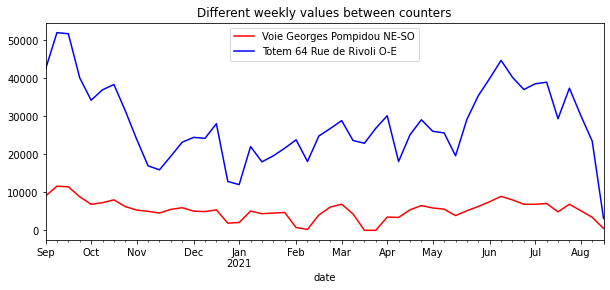

In [153]:
fig, ax = plt.subplots(figsize=(10, 4))

mask1 = data['counter_name'] == 'Voie Georges Pompidou NE-SO'
mask2 = data['counter_name'] == 'Totem 64 Rue de Rivoli O-E'

data[mask1].groupby(pd.Grouper(freq='1w', key='date')).sum().plot(
    y='bike_count', ax=ax, color='r', title='Different weekly values between counters',
    label='Voie Georges Pompidou NE-SO')
data[mask2].groupby(pd.Grouper(freq='1w', key='date')).sum().plot(
    y='bike_count', ax=ax, color='b', label='Totem 64 Rue de Rivoli O-E')